# Введение
●	target_sum – прогнозируемая переменная (объем оборота POS-транзакций клиента в последующие 3 месяца). Для одного клиента cl_id строим один прогноз.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
#ser_ts_sum = train[train['trx_category'] == 'POS'][['cl_id', 'target_sum', 'year', 'month']].groupby(by=['cl_id', 'year', 'month']).sum().astype('int64')
#ser_pos_count = train[train['trx_category'] == 'POS'][['cl_id', 'target_sum', 'year', 'month']].groupby(by=['cl_id', 'year', 'month']).count().rename(columns={'target_sum':'count_POS'}).astype('int64')
#ser_notpos_count = train[train['trx_category'] != 'POS'][['cl_id', 'target_sum', 'year', 'month']].groupby(by=['cl_id', 'year', 'month']).count().rename(columns={'target_sum':'count_notPOS'}).astype('int64')
#train = train.drop(axis=1, labels='target_sum').join(ser_ts_sum, on=['cl_id', 'year', 'month'], how='left').join(ser_pos_count, on=['cl_id', 'year', 'month'], how='left').join(ser_notpos_count, on=['cl_id', 'year', 'month'], how='left')


'''
[description]
InsertDataFrame - pandas dataframe
ColumnName - name of transforming column
'''
def MakeDateYearMonth(InsertDataFrame, ColumnName):
    df = InsertDataFrame.copy()
    df[ColumnName] = pd.to_datetime(df[ColumnName], dayfirst=True)
    df['year'] = df[ColumnName].dt.year
    df['month'] = df[ColumnName].dt.month
    return df    

'''
[description]
InsertDataFrame - pandas dataframe
GroupByList - list of column names
TargetColumn - name of one column in dataframe, string
TargetName - name of returning column
'''
def groupbysum(InsertDataFrame, GroupByList, TargetColumn, TargetName):
    df = InsertDataFrame.copy()
    sdtype = df[TargetColumn].dtype
    ser = df.groupby(by=GroupByList).sum().rename(columns={TargetColumn:TargetName}).astype(sdtype)
    return ser
    
'''
[description]
InsertDataFrame - pandas dataframe
GroupByList - list of column names
TargetColumn - name of one column in dataframe, string
TargetName - name of returning column
'''
def groupbycount(InsertDataFrame, GroupByList, TargetColumn, TargetName):
    df = InsertDataFrame.copy()
    ser = df.groupby(by=GroupByList).count().rename(columns={TargetColumn:TargetName}).astype('int64')
    return ser    

'''
[description]
InsertDataFrame - pandas dataframe
SeriesList - list of pandas series
OnJoin - string or list of column name(s)
'''
def DfLeftJoinSer(InsertDataFrame, SeriesList, OnJoin):
    df = InsertDataFrame.copy()
    for i in SeriesList:
        df = df.join(i, on=OnJoin, how='left')
    return df

In [3]:
url_train = 'https://raw.githubusercontent.com/Hitriihoma/Machine-learning-course-task/master/train.csv'
url_test = 'https://raw.githubusercontent.com/Hitriihoma/Machine-learning-course-task/master/test.csv'

#train = pd.read_csv(url_train)
#test = pd.read_csv(url_test)

#train = pd.read_csv(r'C:/Course/xsolla/Git/Machine-learning-course-task/train.csv')
#test = pd.read_csv(r'C:/Course\xsolla/Git/Machine-learning-course-task/test.csv')

train = pd.read_csv(r'C:/Course/xsolla/Git/Machine-learning-course-task/train.csv')
test = pd.read_csv(r'C:/Course/xsolla/Git/Machine-learning-course-task/test.csv')

In [4]:
train2 = train.copy()

In [5]:
train = train2.copy()
train.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0.0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 9 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_sum      490513 non-null float64
dtypes: float64(2), int64(3), object(4)
memory usage: 33.7+ MB


# Независимые переменные для модели
год, месяц - сколько берём? надо смотреть сколько есть  
количество POS-транзакций  
количество не-POS-транзакций  
сумма POS-транзакций  
сумма не- POS-транзакций

не забываем нормализацию!!!!!

In [7]:
# Входные сырые данные + колонки
train = MakeDateYearMonth(train, 'PERIOD')
group_list = ['cl_id', 'year', 'month']
ser_ts_sum = train[['cl_id', 'target_sum', 'year', 'month']].groupby(by=['cl_id', 'year', 'month']).first().astype('float64')
ser_pos_amount_sum = groupbysum(train[train['trx_category'] == 'POS'][['cl_id', 'amount', 'year', 'month']],
                       group_list,
                       'amount',
                       'sum_pos')
ser_notpos_amount_sum = groupbysum(train[train['trx_category'] != 'POS'][['cl_id', 'amount', 'year', 'month']],
                       group_list,
                       'amount',
                       'sum_notpos')
ser_pos_count = groupbycount(train[train['trx_category'] == 'POS'][['cl_id', 'target_sum', 'year', 'month']],
                       group_list,
                       'target_sum',
                       'count_pos')
ser_notpos_count = groupbycount(train[train['trx_category'] != 'POS'][['cl_id', 'target_sum', 'year', 'month']],
                       group_list,
                       'target_sum',
                       'count_notpos')

train = DfLeftJoinSer(train.drop(axis=1, labels=['PERIOD','MCC', 'channel_type', 'currency', 'TRDATETIME', 'amount', 'trx_category', 'target_sum']).drop_duplicates(),
                      [ser_ts_sum, ser_pos_amount_sum, ser_notpos_amount_sum, ser_pos_count, ser_notpos_count],
                      ['cl_id', 'year', 'month'])
train.head()

,cl_id,year,month,target_sum,sum_pos,sum_notpos,count_pos,count_notpos
0,0,2017,10,0.0,7054.00,56562.0,2.0,2.0
2,0,2017,12,0.0,767.00,NaN,1.0,NaN
5,1,2017,10,0.0,11555.00,NaN,24.0,NaN
9,1,2017,7,0.0,3930.26,50000.0,10.0,1.0
10,1,2017,9,0.0,103285.28,95000.0,60.0,2.0


In [8]:
# Через промедуточный датафрейм
# train_transformed
train_tf = pd.DataFrame(columns=['cl_id', 'target_sum'])
for i in train.cl_id.unique():
    train_tf = train_tf.append(train[train['cl_id'] == i][['cl_id', 'target_sum']].iloc[0])
train_tf = train_tf.astype({'cl_id': 'int64'})
    
for mon in range(1,train.groupby('cl_id').count().month.max()+1): # 14
    train_tf[f'_{mon}_sum_pos'] = np.NaN
    train_tf[f'_{mon}_sum_notpos'] = np.NaN
    train_tf[f'_{mon}_count_pos'] = np.NaN
    train_tf[f'_{mon}_count_notpos'] = np.NaN


#train = train.sort_values(by=['cl_id', 'year', 'month'], ascending=[True, False, False])    
#for ind in train_tf.index[:2]:
    #train_tf.loc[ind, '_1_sum_pos'] = 1

train_tf.head()

,cl_id,target_sum,_1_sum_pos,_1_sum_notpos,_1_count_pos,_1_count_notpos,_2_sum_pos,_2_sum_notpos,_2_count_pos,_2_count_notpos,...,_12_count_pos,_12_count_notpos,_13_sum_pos,_13_sum_notpos,_13_count_pos,_13_count_notpos,_14_sum_pos,_14_sum_notpos,_14_count_pos,_14_count_notpos
0,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,5,326211.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251,9,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
290,10,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
train = train.sort_values(by=['cl_id', 'year', 'month'], ascending=[True, False, False]) 
for ind in train_tf.index:
    mon = 1
    temp_id = train_tf.loc[ind].cl_id
    for ji in train[train['cl_id'] == temp_id].index:
        train_tf.loc[ind,f'_{mon}_sum_pos'] = train.loc[ji,'sum_pos']
        train_tf.loc[ind,f'_{mon}_sum_notpos'] = train.loc[ji,'sum_notpos']
        train_tf.loc[ind,f'_{mon}_count_pos'] = train.loc[ji,'count_pos']
        train_tf.loc[ind,f'_{mon}_count_notpos'] = train.loc[ji,'count_notpos']
        mon+=1
train_tf.fillna(0, inplace=True)
train_tf.head(15)    

,cl_id,target_sum,_1_sum_pos,_1_sum_notpos,_1_count_pos,_1_count_notpos,_2_sum_pos,_2_sum_notpos,_2_count_pos,_2_count_notpos,...,_12_count_pos,_12_count_notpos,_13_sum_pos,_13_sum_notpos,_13_count_pos,_13_count_notpos,_14_sum_pos,_14_sum_notpos,_14_count_pos,_14_count_notpos
0,0,0.00,767.00,0.00,1.0,0.0,7054.00,56562.00,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,0.00,11555.00,0.00,24.0,0.0,103285.28,95000.00,60.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109,5,326211.75,90924.37,88878.38,30.0,7.0,30119.90,47500.00,28.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
251,9,0.00,1559.00,250000.00,13.0,3.0,2206.09,182500.00,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
290,10,0.00,61293.27,43290.00,111.0,12.0,95558.52,829747.88,158.0,48.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
753,11,0.00,6151.05,0.00,22.0,0.0,77543.74,95000.00,88.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
970,14,187776.76,31197.08,0.00,31.0,0.0,72628.55,45700.00,60.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1106,20,0.00,70379.64,60000.00,40.0,1.0,77301.36,80000.00,22.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1183,21,0.00,75433.06,47778.00,35.0,5.0,70058.93,20000.00,52.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1184,22,0.00,511.00,0.00,1.0,0.0,4403.00,5000.00,13.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Анализ данных
какой месяц для модели текущий  
сколько для каждого клиента известно месяцев

In [10]:
# количество уникальных клиентов
print('number of cl_id', len(train.cl_id.unique()), end='\n\n')
print('max count of month', train.groupby('cl_id').count().month.max(), end='\n\n')
print('count of months \n', train.groupby('cl_id').count().year.value_counts(), end='\n\n')
temp_df = train.groupby('cl_id').last()[['year', 'month', 'target_sum']]
temp_df['ym'] = temp_df.apply(lambda row: str(int(row.year))+'-'+str(int(row.month)), axis=1)
print('last month of target_sum > 1 \n', temp_df[temp_df['target_sum'] > 1].ym.value_counts(), end='\n\n' )
print('last month of target_sum < 1 \n', temp_df[temp_df['target_sum'] < 1].ym.value_counts(), end='\n\n' )

number of cl_id 5000

max count of month 14

count of months 
 4     2894
3     1297
2      416
1      217
5      120
6       22
7       12
8        8
9        6
10       4
11       3
14       1
Name: year, dtype: int64

last month of target_sum > 1 
 2016-12    376
2017-7     334
2017-6     329
2017-4     305
2016-11    280
2017-5     274
2017-3     242
2017-2     231
2016-10    100
2017-1      84
2017-8      64
2017-10     38
2017-9      34
2017-11     27
2018-1      16
2018-2      14
2017-12     12
2018-3       6
Name: ym, dtype: int64

last month of target_sum < 1 
 2016-12    410
2016-11    303
2017-4     219
2017-5     203
2017-6     196
2017-2     192
2017-3     191
2017-7     185
2016-10    132
2017-1      69
2017-8      45
2017-10     16
2017-9      16
2017-12     15
2017-11     15
2018-2      11
2018-1       8
2018-3       7
Name: ym, dtype: int64



In [11]:
'''for i in train.cl_id[10:30]:
    fig = plt.figure()
    x = list()
    y = list()
    temp_df = train[train['cl_id'] == i].reset_index(drop=True)
    for ji in temp_df.index:
        j = temp_df.iloc[ji]
        x.append(str(int(j.year))+ '-' + str(int(j.month)))
        y.append(j.pos_sum + j.notpos_sum)
    x.append('target')
    y.append(j.target_sum)
    print(x,y)
    plt.plot(x,y)
    plt.show()
plt.close('all')  
temp_df'''

"for i in train.cl_id[10:30]:\n    fig = plt.figure()\n    x = list()\n    y = list()\n    temp_df = train[train['cl_id'] == i].reset_index(drop=True)\n    for ji in temp_df.index:\n        j = temp_df.iloc[ji]\n        x.append(str(int(j.year))+ '-' + str(int(j.month)))\n        y.append(j.pos_sum + j.notpos_sum)\n    x.append('target')\n    y.append(j.target_sum)\n    print(x,y)\n    plt.plot(x,y)\n    plt.show()\nplt.close('all')  \ntemp_df"

# Формирование выборки

In [20]:
columns_take = ['_1_sum_pos', '_2_sum_pos', '_3_sum_pos', '_4_sum_pos']
columns_drop = ['cl_id', 'target_sum']

train_tf['class'] = train_tf.apply(lambda row: 1 if row['target_sum'] > 10000 else 0, axis=1)

X = train_tf.drop(axis=1, labels=['cl_id', 'target_sum', 'class'])
#X = train_tf[train_tf['target_sum'] != 0].drop(axis=1, labels=['cl_id', 'target_sum'])
#X = train_tf[train_tf['target_sum'] != 0][columns_take]
y = train_tf['target_sum']
y_class = train_tf['class']
#y = train_tf[train_tf['target_sum'] != 0].target_sum
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_trainC, X_testC, y_trainC, y_testC = train_test_split(X, y_class, test_size=0.2, random_state=10)

In [21]:
train_tf.head()

,cl_id,target_sum,_1_sum_pos,_1_sum_notpos,_1_count_pos,_1_count_notpos,_2_sum_pos,_2_sum_notpos,_2_count_pos,_2_count_notpos,...,_12_count_notpos,_13_sum_pos,_13_sum_notpos,_13_count_pos,_13_count_notpos,_14_sum_pos,_14_sum_notpos,_14_count_pos,_14_count_notpos,class
0,0,0.00,767.00,0.00,1.0,0.0,7054.00,56562.00,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,1,0.00,11555.00,0.00,24.0,0.0,103285.28,95000.00,60.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
109,5,326211.75,90924.37,88878.38,30.0,7.0,30119.90,47500.00,28.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
251,9,0.00,1559.00,250000.00,13.0,3.0,2206.09,182500.00,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
290,10,0.00,61293.27,43290.00,111.0,12.0,95558.52,829747.88,158.0,48.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [22]:
X.head()

,_1_sum_pos,_1_sum_notpos,_1_count_pos,_1_count_notpos,_2_sum_pos,_2_sum_notpos,_2_count_pos,_2_count_notpos,_3_sum_pos,_3_sum_notpos,...,_12_count_pos,_12_count_notpos,_13_sum_pos,_13_sum_notpos,_13_count_pos,_13_count_notpos,_14_sum_pos,_14_sum_notpos,_14_count_pos,_14_count_notpos
0,767.00,0.00,1.0,0.0,7054.00,56562.00,2.0,2.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,11555.00,0.00,24.0,0.0,103285.28,95000.00,60.0,2.0,3807.50,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109,90924.37,88878.38,30.0,7.0,30119.90,47500.00,28.0,9.0,117748.12,93500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
251,1559.00,250000.00,13.0,3.0,2206.09,182500.00,4.0,2.0,8600.00,404450.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
290,61293.27,43290.00,111.0,12.0,95558.52,829747.88,158.0,48.0,44104.32,50350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
y.head()

0           0.00
5           0.00
109    326211.75
251         0.00
290         0.00
Name: target_sum, dtype: float64

# Модель

## Сначала классификация на больше-меньше 10000

In [59]:
from sklearn.linear_model import LogisticRegression
LoR = LogisticRegression(random_state=0, max_iter=1000).fit(X_trainC, y_trainC)
LoR_pred = LoR.predict(X_testC)
r2_score(y_testC, LR_pred)

-46752401901.81564

In [40]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(max_depth=2, random_state=0).fit(X_trainC, y_trainC)
RFC_pred = RFC.predict(X_testC)
r2_score(y_testC, RFC_pred)

-0.07496785237649006

In [41]:
from sklearn.ensemble import GradientBoostingClassifier
GBC = GradientBoostingClassifier(max_depth=2, random_state=0).fit(X_trainC, y_trainC)
GBC_pred = GBC.predict(X_testC)
r2_score(y_testC, GBC_pred)

0.1156868233280196

In [81]:
up = 1
down = 0

res = pd.DataFrame(y_testC)
res['LoR'] = LoR_pred
res['delta_LoR'] = abs(res['class'] - res['LoR'])
res['RFC'] = RFC_pred
res['delta_RFC'] = abs(res['class'] - res['RFC'])
res['GBC'] = GBC_pred
res['delta_GBC'] = abs(res['class'] - res['GBC'])
#res[(res['delta_LR'] == up) | (res['delta_nnls'] == up) | (res['delta_MLPR'] == up)][['target_sum', 'delta_LR', 'delta_nnls', 'delta_MLPR']]
print('True results from 1000')
print('LoR',len(res[(res['delta_LoR'] == down)]))
print('RFC',len(res[(res['delta_RFC'] == down)]))
print('GBC',len(res[(res['delta_GBC'] == down)]))
#res[(res['delta_LoR'] == down) | (res['delta_RFC'] == down) | (res['delta_GBC'] == down)][['class', 'delta_LoR', 'delta_RFC', 'delta_GBC']]

True results from 1000
LoR 605
RFC 735
GBC 782


## Выбираем для тренировки регрессии то, что классифицируется как 1

In [67]:
X_train_cd = X_train.copy()
X_train_cd['classified'] = GBC.predict(X_train)
#X_train_cd[X_train_cd['classified'] == 1]
X_train_2nd = X_train_cd[X_train_cd['classified'] == 1].drop(axis=1, labels=['classified'])
y_train_2nd = y_train[y_train.index.isin(X_train_2nd.index)]

## Тренируем регрессию

In [68]:
from scipy.optimize import nnls
nnls_sv_2nd = nnls(X_train_2nd, y_train_2nd)[0]

## Применяем модели

In [86]:
X_test_cd = X_test.copy()
GBC_pred = GBC.predict(X_test)
X_test_cd['classified'] = GBC_pred
nnls_pred_2nd = X_test.apply(lambda row: np.sum(row.to_numpy()*nnls_sv_2nd), axis=1)
X_test_cd['regression'] = nnls_pred_2nd
X_test_cd['predicted'] = X_test_cd.apply(lambda row: 0 if (row['classified']==0) else row['regression'], axis=1)
y_pred = X_test_cd['predicted']
r2_score(y_test, y_pred)

0.010249764052004062

## Регрессия чистая

In [79]:
# Non-negative least squares
from scipy.optimize import nnls
nnls_sv = nnls(X_train, y_train)[0]
nnls_pred = X_test.apply(lambda row: np.sum(row.to_numpy()*nnls_sv), axis=1)
r2_score(y_test, nnls_pred)

0.006276970210394417

In [80]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression().fit(X_train, y_train)
LR_pred = LR.predict(X_test)
#LR.score(X_test,y_test.to_numpy())
#LR.score(X_test,y_test)
r2_score(y_test, LR_pred)

0.00620401219747535

In [27]:
from sklearn.ensemble import RandomForestRegressor
RFR = RandomForestRegressor(max_depth=2, random_state=0).fit(X_train, y_train)
RFR_pred = RFR.predict(X_test)
RFR.score(X_test,y_test.to_numpy())

-0.04983814809447917

In [28]:
from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor(random_state=0, max_depth=3).fit(X_train, y_train)
GBR_pred = GBR.predict(X_test)
GBR.score(X_test,y_test.to_numpy())

-0.018452302884903293

In [29]:
from sklearn.neural_network import MLPRegressor
MLPR = MLPRegressor(random_state=0, max_iter=500).fit(X_train, y_train)
MLPR_pred = MLPR.predict(X_test)
MLPR.score(X_test,y_test.to_numpy())

0.0065574144996392025

Text(0.5, 1.0, 'two models')

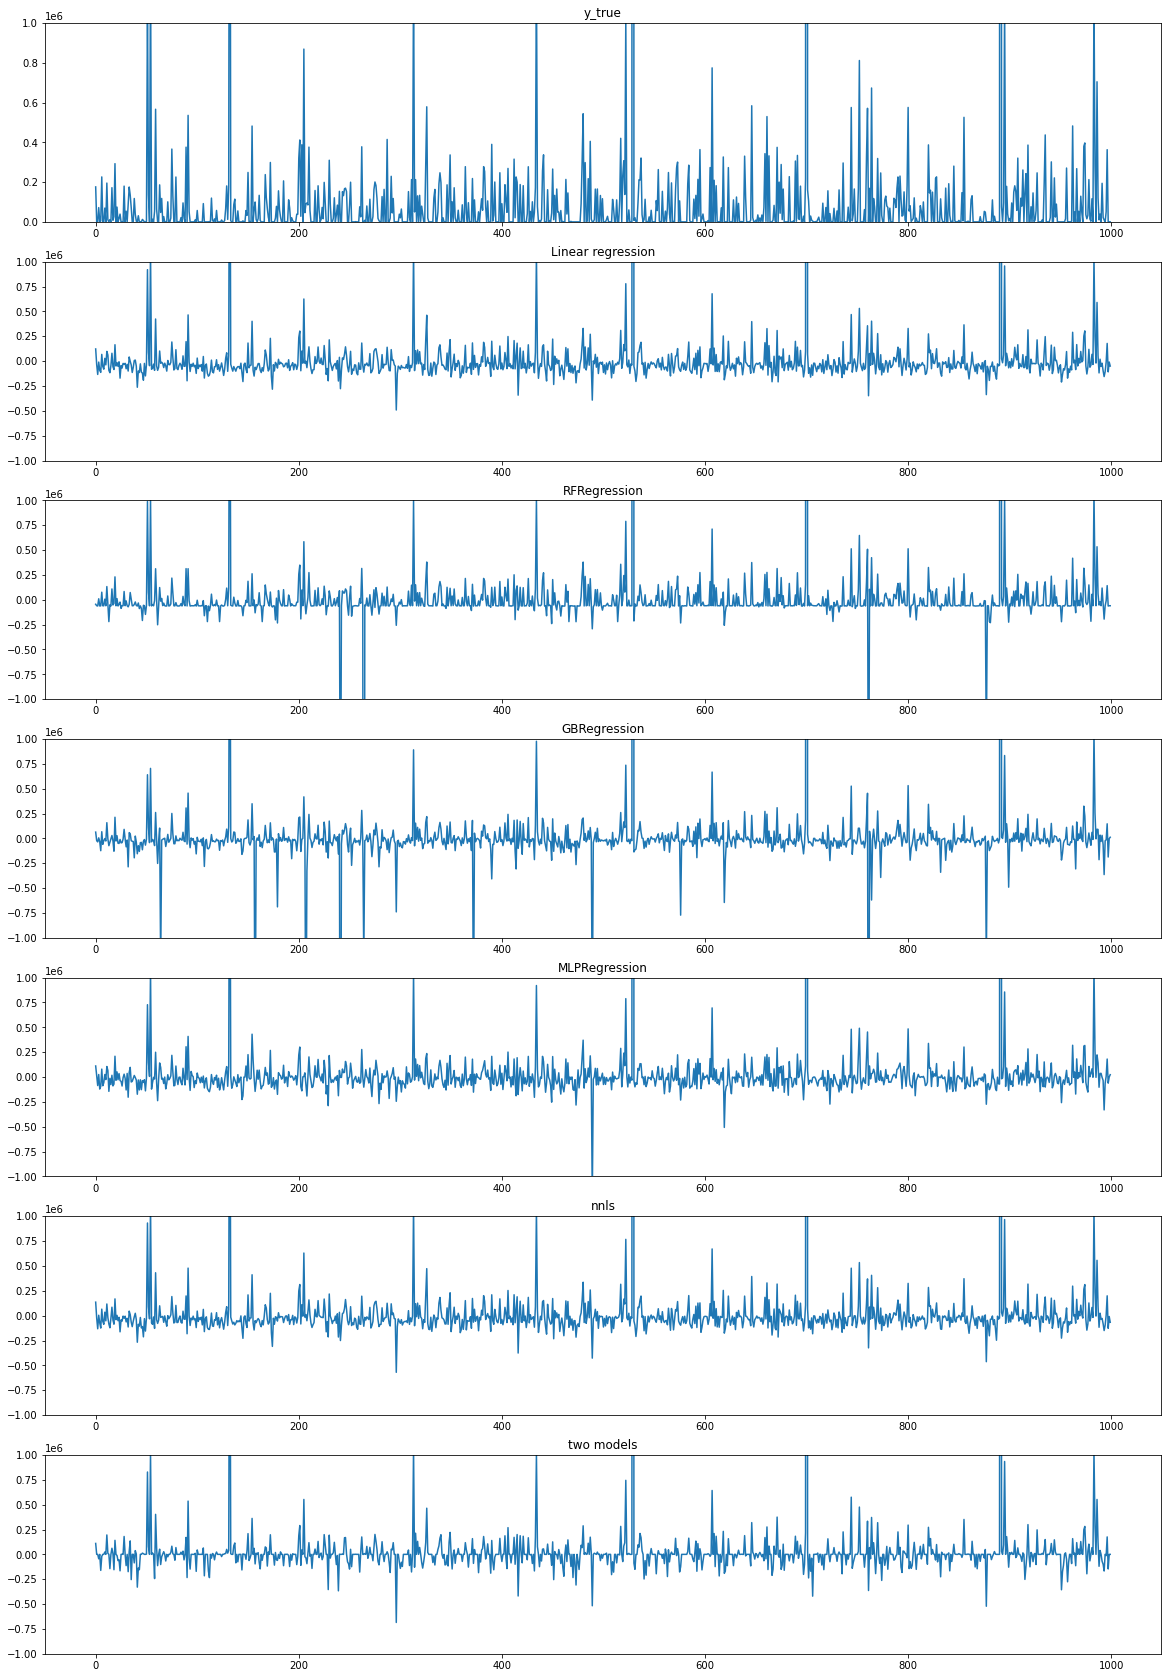

In [83]:
fig, ax = plt.subplots(7,1, figsize = (20,30))
ax[0].plot(np.arange(0,len(X_test)), y_test)
ax[1].plot(np.arange(0,len(X_test)), y_test.to_numpy() - LR_pred)
ax[2].plot(np.arange(0,len(X_test)), y_test.to_numpy() - RFR_pred)
ax[3].plot(np.arange(0,len(X_test)), y_test.to_numpy() - GBR_pred)
ax[4].plot(np.arange(0,len(X_test)), y_test.to_numpy() - MLPR_pred)
ax[5].plot(np.arange(0,len(X_test)), y_test.to_numpy() - nnls_pred)
ax[6].plot(np.arange(0,len(X_test)), y_test.to_numpy() - y_pred)

ax[0].set_ylim(0,1000000)
ax[1].set_ylim(-1000000,1000000)
ax[2].set_ylim(-1000000,1000000)
ax[3].set_ylim(-1000000,1000000)
ax[4].set_ylim(-1000000,1000000)
ax[5].set_ylim(-1000000,1000000)
ax[6].set_ylim(-1000000,1000000)

ax[0].set_title('y_true')
ax[1].set_title('Linear regression')
ax[2].set_title('RFRegression')
ax[3].set_title('GBRegression')
ax[4].set_title('MLPRegression')
ax[5].set_title('nnls')
ax[6].set_title('two models')

In [37]:
up = 400000
down = 10000 # 10000 - 231rows предсказано с меньшей ошибкой

res = pd.DataFrame(y_test)
res['LR'] = LR_pred
res['delta_LR'] = abs(res['target_sum'] - res['LR'])
res['nnls'] = nnls_pred
res['delta_nnls'] = abs(res['target_sum'] - res['nnls'])
res['MLPR'] = MLPR_pred
res['delta_MLPR'] = abs(res['target_sum'] - res['MLPR'])
#res[(res['delta_LR'] > up) | (res['delta_nnls'] > up) | (res['delta_MLPR'] > up)][['target_sum', 'delta_LR', 'delta_nnls', 'delta_MLPR']]
res[(res['delta_LR'] < down) | (res['delta_nnls'] < down) | (res['delta_MLPR'] < down)][['target_sum', 'delta_LR', 'delta_nnls', 'delta_MLPR']]

,target_sum,delta_LR,delta_nnls,delta_MLPR
447279,0.00,36016.787761,23923.172131,7693.088455
243394,71715.42,9918.768524,4721.482067,25490.877592
361817,74281.45,15388.331045,3525.385527,52075.746134
127489,17157.80,7076.193884,15951.890830,35280.330131
381032,0.00,23343.920423,4231.005403,5684.533794
220486,0.00,22452.271108,5037.402824,12197.081175
233168,135308.36,2542.869124,11222.281579,97571.610969
166251,117575.10,5923.962243,11615.983047,15995.228828
214057,37913.05,10182.231133,24428.668943,4639.461328
409351,2397.69,36190.287536,22699.054683,6701.421531


## Со стандартизацией

In [152]:
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = train_tf[train_tf['target_sum'] != 0].drop(axis=1, labels=['cl_id', 'target_sum'])
y = train_tf[train_tf['target_sum'] != 0].target_sum.to_numpy().reshape(-1, 1)
scaler_X.fit_transform(X)
scaler_y.fit_transform(y)
X_trainS, X_testS, y_trainS, y_testS = train_test_split(X, y, test_size=0.2, random_state=10)